![qiskit_header.png](../../images/qiskit_header.png)

# _*Qiskit Aqua: Generating Random Variates*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-iqx-tutorials.

***
### Contributors
Albert Akhriev<sup>[1]</sup>, Jakub Marecek<sup>[1]</sup>

### Affiliation
- <sup>[1]</sup>IBMQ

## Introduction

While classical computers use only pseudo-random routines, quantum computers
can generate true random variates.
For example, the measurement of a quantum superposition is intrinsically random,
as suggested by Born's rule.
Consequently, some of the
best random-number generators are based on such quantum-mechanical effects.
Further, with a logarithmic amount of random bits, quantum computers can produce
linearly many more bits, which is known as 
randomness expansion protocols. 

In practical applications, one wishes to use random variates of well-known
distributions, rather than random bits.
In this notebook, we illustrate ways of generating random variates of several popular
distributions on IBM Q.

## Random Bits and the Bernoulli distribution

It is clear that there are many options for generating random bits (i.e., Bernoulli-distributed scalars, taking values either 0 or 1). Starting from a simple circuit such as a Hadamard gate followed by measurement, one can progress to vectors of Bernoulli-distributed elements. By addition of such random variates, we could get binomial distributions. By multiplication we could get geometric distributions, although perhaps leading to a circuit depth that may be impractical at the moment, though.

Let us start by importing the basic modules and creating a quantum circuit for generating random bits:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys, math, time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from qiskit import Aer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute

# In this example we use 'qasm_simulator' backend.
glo_backend = Aer.get_backend("qasm_simulator")

In the next step we create a quantum circuit, which will be used for generation:

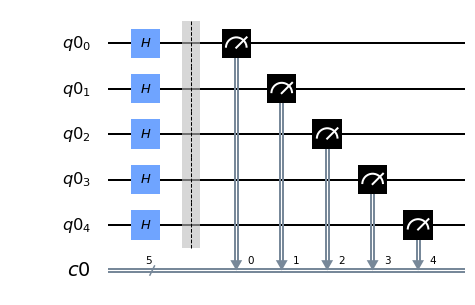

In [2]:
# Number of qubits utilised simultaneously.
glo_num_qubits = 5

def create_circuit(num_target_qubits: int) -> QuantumCircuit:
    """
    Creates and returns quantum circuit for random variate generation.
    :param num_target_qubits: number of qubits to be used.
    :return: quantum curcuit.
    """
    assert isinstance(num_target_qubits, int) and num_target_qubits > 0
    q = QuantumRegister(num_target_qubits)
    c = ClassicalRegister(num_target_qubits)
    circuit = QuantumCircuit(q, c)
    circuit.h(q)
    circuit.barrier()
    circuit.measure(q, c)
    return circuit

# Create and plot generating quantum circuit.
circuit = create_circuit(glo_num_qubits)
#print(circuit)
circuit.draw(output='mpl')

## Uniformly-distributed scalars and vectors

It is clear that there are many options for approximating uniformly-distributed scalars by the choice of an integer from a finite range uniformly at random, e.g., by a binary-code construction from the Bernoulli-distributed vectors. In the following snippet, we generate random bits, which we then convert using the binary-code construction, up to the machine precision of a classical computer.

In [3]:
def uniform_rand_float64(circuit: QuantumCircuit, num_target_qubits: int,
                         size: int, vmin: float, vmax: float) -> np.ndarray:
    """
    Generates a vector of random float64 values in the range [vmin, vmax].
    :param circuit: quantum circuit for random variate generation.
    :param num_target_qubits: number of qubits to be used.
    :param size: length of the vector.
    :param vmin: lower bound.
    :param vmax: upper bound.
    :return: vector of random values.
    """
    assert sys.maxsize == np.iinfo(np.int64).max    # sizeof(int) == 64 bits
    assert isinstance(size, int) and size > 0
    assert isinstance(vmin, float) and isinstance(vmax, float) and vmin <= vmax
    nbits = 7 * 8                                   # nbits > mantissa of float64
    bit_str_len = (nbits * size + num_target_qubits - 1) // num_target_qubits
    job = execute(circuit, glo_backend, shots=bit_str_len, memory=True)
    bit_str = ''.join(job.result().get_memory())
    scale = float(vmax - vmin) / float(2**nbits - 1)
    return np.array([vmin + scale * float(int(bit_str[i:i+nbits], 2))
                     for i in range(0, nbits * size, nbits)], dtype=np.float64)

def uniform_rand_int64(circuit: QuantumCircuit, num_target_qubits: int,
                       size: int, vmin: int, vmax: int) -> np.ndarray:
    """
    Generates a vector of random int64 values in the range [vmin, vmax].
    :param circuit: quantum circuit for random variate generation.
    :param num_target_qubits: number of qubits to be used.
    :param size: length of the vector.
    :param vmin: lower bound.
    :param vmax: upper bound.
    :return: vector of random values.
    """
    assert sys.maxsize == np.iinfo(np.int64).max        # sizeof(int) == 64 bits
    assert isinstance(size, int) and size > 0
    assert isinstance(vmin, int) and isinstance(vmax, int) and vmin <= vmax
    assert abs(vmin) <= 2**52 and abs(vmax) <= 2**52    # 52 == mantissa of float64
    return np.rint(uniform_rand_float64(circuit, num_target_qubits,
                                        size, float(vmin), float(vmax))).astype(np.int64)

### Uniform distribution over floating point numbers.
In this example we draw a random vector of floating-point values uniformly distributed within some arbitrary selected interval:

Uniform distribution over floating point numbers:
  sample type: <class 'numpy.ndarray'> , element type: float64 , shape: (54321,)
  sample min: -7.6692, max: 19.5197
  sampling time: 4.88 secs


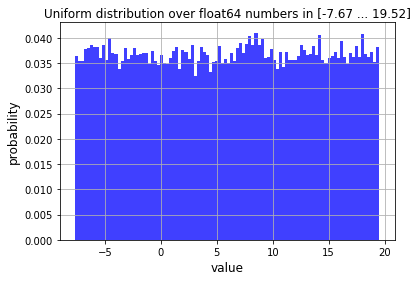

In [4]:
# Draw a sample from uniform distribution.
start_time = time.time()
sample = uniform_rand_float64(circuit, glo_num_qubits, size=54321, vmin=-7.67, vmax=19.52)
sampling_time = time.time() - start_time

# Print out some details.
print("Uniform distribution over floating point numbers:")
print("  sample type:", type(sample), ", element type:", sample.dtype, ", shape:", sample.shape)
print("  sample min: {:.4f}, max: {:.4f}".format(np.amin(sample), np.amax(sample)))
print("  sampling time: {:.2f} secs".format(sampling_time))

# Plotting the distribution.
plt.hist(sample.ravel(),
         bins=min(int(np.ceil(np.sqrt(sample.size))), 100),
         density=True, facecolor='b', alpha=0.75)
plt.xlabel("value", size=12)
plt.ylabel("probability", size=12)
plt.title("Uniform distribution over float64 numbers in [{:.2f} ... {:.2f}]".format(
            np.amin(sample), np.amax(sample)), size=12)
plt.grid(True)
# plt.savefig("uniform_distrib_float.png", bbox_inches="tight")
plt.show()

### Uniform distribution over integers.
Our next example is similar to the previous one, but here we generate a random vector of integers:

Uniform distribution over bounded integer numbers:
  sample type: <class 'numpy.ndarray'> , element type: int64 , shape: (54321,)
  sample min: 37, max: 841
  sampling time: 4.79 secs


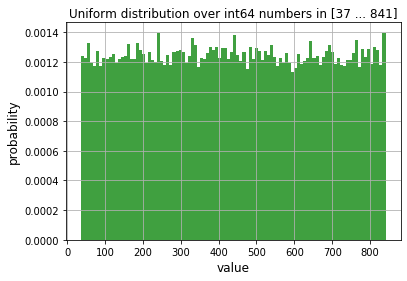

In [5]:
# Draw a sample from uniform distribution.
start_time = time.time()
sample = uniform_rand_int64(circuit, glo_num_qubits, size=54321, vmin=37, vmax=841)
sampling_time = time.time() - start_time

# Print out some details.
print("Uniform distribution over bounded integer numbers:")
print("  sample type:", type(sample), ", element type:", sample.dtype, ", shape:", sample.shape)
print("  sample min: {:d}, max: {:d}".format(np.amin(sample), np.amax(sample)))
print("  sampling time: {:.2f} secs".format(sampling_time))

# Plotting the distribution.
plt.hist(sample.ravel(),
         bins=min(int(np.ceil(np.sqrt(sample.size))), 100),
         density=True, facecolor='g', alpha=0.75)
plt.xlabel("value", size=12)
plt.ylabel("probability", size=12)
plt.title("Uniform distribution over int64 numbers in [{:d} ... {:d}]".format(
            np.amin(sample), np.amax(sample)), size=12)
plt.grid(True)
# plt.savefig("uniform_distrib_int.png", bbox_inches="tight")
plt.show()

## Normal distribution

To generate random variates with a standard normal distribution using two independent 
samples $u_1, u_2$ of the uniform distribution on the unit interval [0, 1], one can
consider the Box-Muller transform to obtain a 2-vector:

\begin{align}
\begin{bmatrix}
%R\cos(\Theta )=
{\sqrt {-2\ln u_{1}}}\cos(2\pi u_{2}) \\
% R\sin(\Theta )=
{\sqrt {-2\ln u_{1}}}\sin(2\pi u_{2})
\end{bmatrix},
\end{align}

wherein we have two independent samples of the standard normal distribution.
In IBM Q, this is implemented as follows: 

In [6]:
def normal_rand_float64(circuit: QuantumCircuit, num_target_qubits: int,
                        size: int, mu: float, sigma: float) -> np.ndarray:
    """
    Draws a sample vector from the normal distribution given the mean and standard
    deviation, using the Box-Muller method. 
    """
    TINY = np.sqrt(np.finfo(np.float64).tiny)
    assert isinstance(size, int) and size > 0
    rand_vec = np.zeros((size,), dtype=np.float64)

    # Generate array of uniformly distributed samples, factor 1.5 longer that
    # actually needed.
    n = (3 * size) // 2
    x = np.reshape(uniform_rand_float64(circuit, num_target_qubits,
                                        2*n, 0.0, 1.0), (-1, 2))

    x1 = 0.0                # first sample in a pair
    c = 0                   # counter
    for d in range(size):
        r2 = 2.0
        while r2 >= 1.0 or r2 < TINY:
            # Regenerate array of uniformly distributed samples upon shortage.
            if c >= n:
                c = 0
                n = max(size // 10, 1)
                x = np.reshape(uniform_rand_float64(circuit, num_target_qubits,
                                                    2*n, 0.0, 1.0), (-1, 2))

            x1 = 2.0 * x[c, 0] - 1.0        # first sample in a pair
            x2 = 2.0 * x[c, 1] - 1.0        # second sample in a pair
            r2 = x1 * x1 + x2 * x2
            c += 1

        f = np.sqrt(np.abs(-2.0 * np.log(r2) / r2))
        rand_vec[d] = f * x1
        
    return (rand_vec * sigma + mu)

The following example demonstrates how to draw a random vector of normally distributed variates:

Normal distribution (mu=2.400, sigma=5.100):
  sample type: <class 'numpy.ndarray'> , element type: float64 , shape: (4321,)
  sample min: -17.9829, max: 19.2452
  sampling time: 1.02 secs


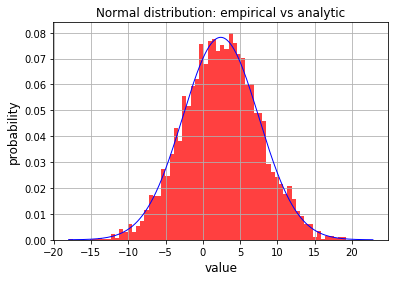

In [7]:
# Mean and standard deviation.
mu = 2.4
sigma = 5.1

# Draw a sample from the normal distribution.
start_time = time.time()
sample = normal_rand_float64(circuit, glo_num_qubits, size=4321, mu=mu, sigma=sigma)
sampling_time = time.time() - start_time

# Print out some details.
print("Normal distribution (mu={:.3f}, sigma={:.3f}):".format(mu, sigma))
print("  sample type:", type(sample), ", element type:", sample.dtype, ", shape:", sample.shape)
print("  sample min: {:.4f}, max: {:.4f}".format(np.amin(sample), np.amax(sample)))
print("  sampling time: {:.2f} secs".format(sampling_time))

# Plotting the distribution.
x = np.linspace(mu - 4.0 * sigma, mu + 4.0 * sigma, 1000)
analyt = np.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * math.sqrt(2.0 * math.pi))
plt.hist(sample.ravel(),
         bins=min(int(np.ceil(np.sqrt(sample.size))), 100),
         density=True, facecolor='r', alpha=0.75)
plt.plot(x, analyt, '-b', lw=1)
plt.xlabel("value", size=12)
plt.ylabel("probability", size=12)
plt.title("Normal distribution: empirical vs analytic", size=12)
plt.grid(True)
# plt.savefig("normal_distrib.png", bbox_inches="tight")
plt.show()

There is a substantial amount of further work needed to either certify the quality of the source of random numbers (cf. NIST SP 800-90B, Recommendation for the Entropy Sources Used for Random Bit Generation) or to use random variates within quantum algorithms (cf. <a href="https://github.com/Qiskit/qiskit-aqua/tree/master/qiskit/aqua/components/uncertainty_models">uncertainty_models</a> within Qiskit Aqua).

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright